<a href="https://www.kaggle.com/code/gauravghatuary/brain-eeg-classification?scriptVersionId=235436486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Importing libraries

from pathlib import Path
import re

import matplotlib.pyplot as plt

import json

In [3]:
#Setting the seed for np

np.random.seed(42)

# Overview

This project is based on the Kaggle competetion to detect and classify seizures and other types of harmful brain activity.
Here the main goal is to develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

**What is EEG?**

**Electroencephalography**, commonly referred to as **EEG**, is a non-invasive method used to record electrical activity in the brain. This technique involves placing electrodes on the scalp, which detect tiny electrical charges that result from the activity of brain cells. The signals captured by these electrodes are amplified and recorded, typically resulting in a series of wavy lines that are analyzed by specialists

**Patterns for classification**

There are six patterns of interest for this competition: seizure (SZ), generalized periodic discharges (GPD), lateralized periodic discharges (LPD), lateralized rhythmic delta activity (LRDA), generalized rhythmic delta activity (GRDA), or “other

The EEG segments used in this competition have been annotated, or classified, by a group of experts. 
In some cases experts completely agree about the correct label.On other cases the experts disagree. 

* We call segments where there are high levels of agreement **“idealized” patterns**.
* Cases where ~1/2 of experts give a label as “other” and ~1/2 give one of the remaining five labels, we call **“proto patterns”**.
* Cases where experts are approximately split between 2 of the 5 named patterns, we call **“edge cases”**.

# Exploring the Data

In [4]:
#exploring the  files
current_path=Path(os.getcwd())
input_path=Path('/kaggle/input/hms-harmful-brain-activity-classification')

os.listdir(input_path)

['train_eegs',
 'sample_submission.csv',
 'train_spectrograms',
 'test_eegs',
 'example_figures',
 'test_spectrograms',
 'train.csv',
 'test.csv']

In [5]:
#Defing the spectrograms and eegs dir
train_spectrogram_dir=input_path/'train_spectrograms'
train_eegs_dir=input_path/'train_eegs'

test_spectrogram_dir=input_path/'test_spectrograms'
test_eegs_dir=input_path/'test_eegs'

In [6]:
#Checking the train data
train_data=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
train_data

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [7]:
train_data.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

**Columns of dataset:**

**eeg_id** - A unique identifier for the entire EEG recording.

**eeg_sub_id** - An ID for the specific 50 second long subsample this row's labels apply to.

**eeg_label_offset_seconds** - The time between the beginning of the consolidated EEG and this subsample.

**spectrogram_id** - A unique identifier for the entire EEG recording.

**spectrogram_sub_id** - An ID for the specific 10 minute subsample this row's labels apply to.

**spectogram_label_offset_seconds** - The time between the beginning of the consolidated spectrogram and this subsample.

**label_id** - An ID for this set of labels.

**patient_id** - An ID for the patient who donated the data.

**expert_consensus** - The consensus annotator label. Provided for convenience only.

**seizure/lpd/gpd/lrda/grda/other_vote** - The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows: lpd: lateralized periodic discharges, gpd: generalized periodic discharges, lrd: lateralized rhythmic delta activity, and grda: generalized rhythmic delta activity 


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [9]:
print(f"No of patients:{train_data['patient_id'].nunique()}")

No of patients:1950


<Axes: xlabel='expert_consensus'>

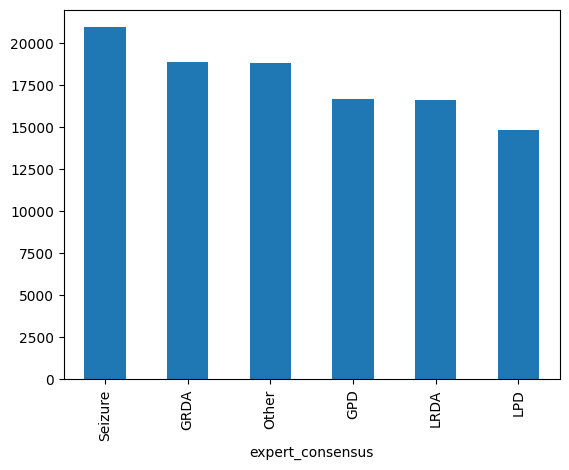

In [10]:
train_data['expert_consensus'].value_counts().plot(kind='bar')

In [11]:
vote_columns=['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_data[vote_columns].value_counts()

seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
3             0         0         0          0          0             17520
0             0         0         0          3          0             11250
                                  3          0          0              5275
                                  0          0          3              2722
                                                        1              1835
                                                                      ...  
11            0         0         0          0          4                 1
0             0         3         0          1          14                1
                                             4          6                 1
              1         0         1          1          8                 1
                                                        9                 1
Name: count, Length: 3350, dtype: int64

We can see that there are various combinations of types of votes, and we will classify and add a column based on whether they are :
* idealized- high levels of agreement
* proto- Cases where ~1/2 of experts give a label as “other” and ~1/2 give one of the remaining five labels
* edge-Cases where experts are approximately split between 2 of the 5 named patterns,


In [12]:

#Calculating total votes
train_data['total_vote']=train_data[vote_columns].sum(axis=1)

#Calculating the normalized vote for each
for col in vote_columns:
    train_data[col+'_n']=train_data[col]/train_data['total_vote']

train_data


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
vote_columns_n=[x+'_n' for x in vote_columns]
train_data[vote_columns_n].value_counts()

seizure_vote_n  lpd_vote_n  gpd_vote_n  lrda_vote_n  grda_vote_n  other_vote_n
1.000000        0.000000    0.000000    0.0          0.00         0.000000        18245
0.000000        0.000000    0.000000    0.0          1.00         0.000000        11673
                                                     0.00         1.000000         7486
                                        1.0          0.00         0.000000         5551
                1.000000    0.000000    0.0          0.00         0.000000         5062
                                                                                  ...  
0.700000        0.000000    0.000000    0.3          0.00         0.000000            1
0.705882        0.117647    0.176471    0.0          0.00         0.000000            1
0.722222        0.000000    0.222222    0.0          0.00         0.055556            1
0.733333        0.000000    0.000000    0.0          0.00         0.266667            1
0.750000        0.000000    0.000000    0

In [14]:
#Defining a function to classify eeg data according to vote distribution

def classify_pattern(x):
    named_columns=['seizure_vote_n',  'lpd_vote_n',  'gpd_vote_n',  'lrda_vote_n',  'grda_vote_n']
    #Agreeing on one type
    if np.any(x[vote_columns_n]>0.95):
        pattern='idealized'
    #Agreeing on other and named
    elif np.any(x[named_columns]>0.45) and x['other_vote_n']>0.45:
        pattern='proto'
    else:
        pattern= 'edge'
    return pattern

In [120]:
train_data['pattern']=train_data.apply(lambda x:classify_pattern(x),axis=1)
train_data


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n,pattern
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,idealized
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,idealized
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,idealized
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,idealized
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,idealized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0,idealized
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0,idealized
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0,idealized
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,...,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0,idealized


<Axes: xlabel='pattern'>

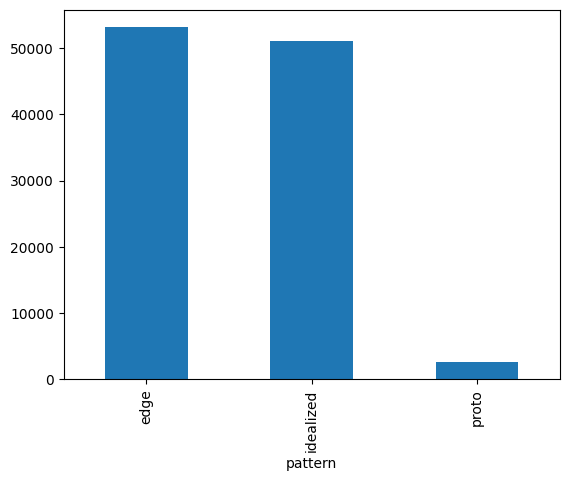

In [121]:
#Visualizing distribution of pattern
train_data['pattern'].value_counts().plot(kind='bar')

In [17]:
#Checking the test data
test_data=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
test_data

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


## EEG Data

In [18]:
print(f'Nos. of train eeg files:{len(os.listdir(train_eegs_dir))}')
eegs_list=os.listdir(train_eegs_dir)

Nos. of train eeg files:17300


In [19]:
sample_eeg=train_eegs_dir/eegs_list[2]
sample_eeg

PosixPath('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3959808174.parquet')

In [20]:
eeg_id=re.search(r'[0-9]+',str(sample_eeg)).group()
train_data[train_data['eeg_id']==int(eeg_id)]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n
40810,3959808174,0,0.0,784750288,30,1139.0,1269517314,29441,LPD,0,...,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
#Reading a sample eeg file

pd.read_parquet(sample_eeg)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-31.129999,-34.029999,-85.910004,-54.650002,-44.220001,-100.620003,-56.389999,-61.439999,21.059999,71.949997,-12.970000,-45.720001,-23.809999,49.259998,22.490000,-10.060000,2.11,6.710000,0.070000,-1425.859985
1,-28.040001,-29.059999,-82.050003,-52.439999,-39.549999,-95.570000,-51.709999,-58.930000,19.700001,72.739998,-16.129999,-43.189999,-21.070000,50.740002,23.580000,-8.840000,3.68,7.510000,-0.010000,-106.720001
2,-23.520000,-22.530001,-75.129997,-45.259998,-31.860001,-86.300003,-43.290001,-52.860001,27.030001,80.989998,-8.420000,-41.599998,-16.139999,55.840000,27.469999,-5.720000,6.38,10.840000,3.350000,1278.859985
3,-19.660000,-22.469999,-76.250000,-44.910000,-32.730000,-85.339996,-42.919998,-53.700001,34.669998,84.239998,-4.950000,-38.779999,-16.180000,54.549999,25.389999,-9.880000,2.28,7.680000,1.420000,-902.020020
4,-18.559999,-23.350000,-77.860001,-47.830002,-33.290001,-84.989998,-43.619999,-55.680000,28.430000,79.099998,-11.290000,-41.840000,-20.230000,48.430000,21.049999,-16.510000,-2.58,3.110000,-2.020000,-940.299988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,48.700001,38.099998,-11.090000,2.220000,13.740000,-29.969999,6.660000,-25.490000,99.739998,109.580002,-13.140000,53.369999,41.389999,46.630001,-21.690001,13.750000,-3.07,-30.980000,-39.200001,-1121.010010
9996,51.540001,41.150002,-9.210000,4.170000,15.290000,-28.459999,8.600000,-22.559999,98.410004,108.760002,-14.200000,56.139999,44.130001,49.849998,-17.590000,17.120001,0.21,-28.030001,-35.529999,-649.729980
9997,53.549999,48.099998,-2.270000,11.820000,22.230000,-20.170000,15.600000,-13.560000,103.650002,115.889999,-5.920000,58.220001,50.389999,59.200001,-7.140000,24.950001,9.42,-18.219999,-26.090000,1418.550049
9998,52.060001,45.880001,-5.240000,10.620000,19.350000,-23.090000,12.100000,-14.920000,108.300003,119.370003,0.110000,58.970001,48.669998,60.160000,-5.320000,22.340000,9.55,-16.850000,-23.600000,-306.570007


**EEG data from one or more overlapping samples.** 
The column names are the names of the individual electrode locations for EEG leads, with one exception. The EKG column is for an electrocardiogram lead that records data from the heart. All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second.

There are 20 columns of 10000 rows.

No of seconds for which data was collected=10000/200 sec=50 sec

In [22]:
#Defining a function to plot EEG

def plot_eeg(eeg_path):
    sample_eeg=pd.read_parquet(eeg_path)

    for i,col in enumerate(sample_eeg.columns):
        fig=plt.figure(figsize=(5,30))
        ax=plt.subplot(20,1,i+1)
        ax.plot(sample_eeg[col])
        ax.set_xlabel(col)
        plt.grid()

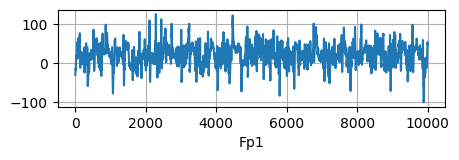

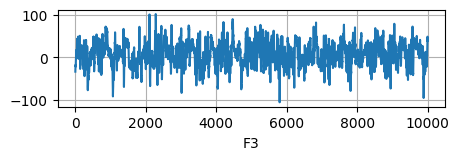

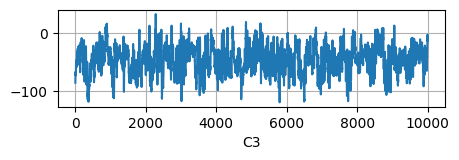

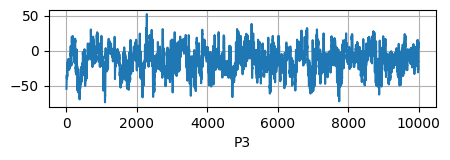

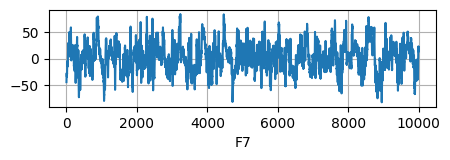

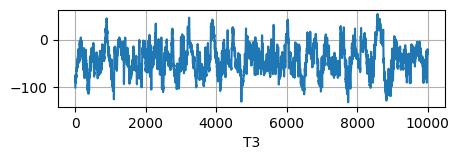

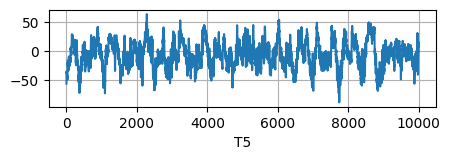

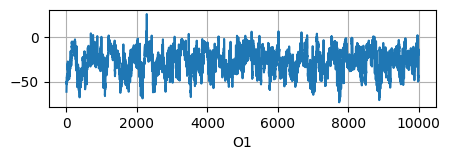

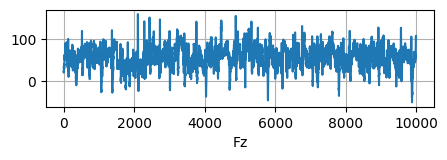

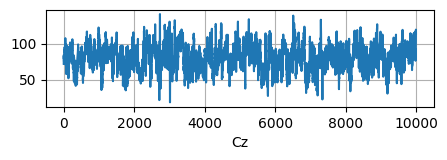

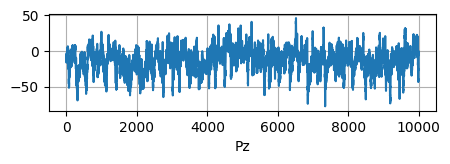

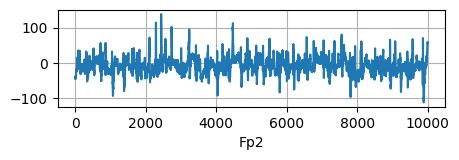

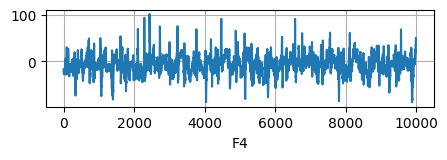

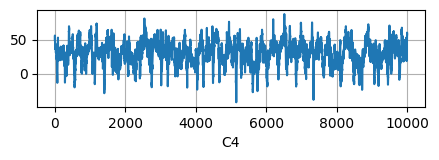

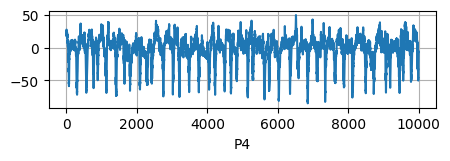

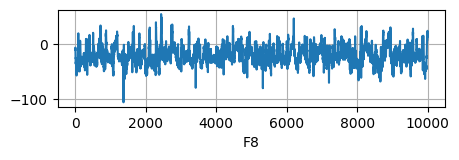

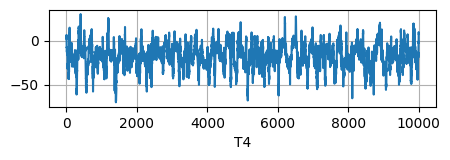

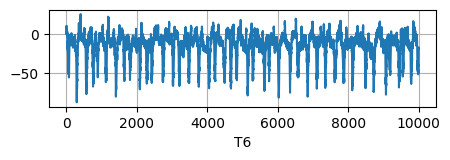

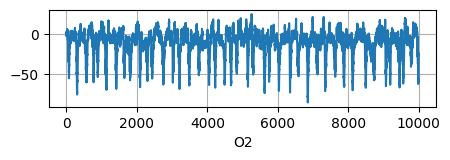

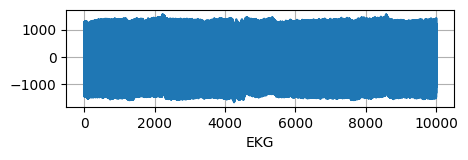

In [23]:
plot_eeg(eeg_path=sample_eeg)

**Insights from the plot:**
* Data has a lot of peaks and troughs
* Most of variation is within -100 to +100 except EKG

In [24]:
#Checking the test eeg
print(f'Nos. of test eeg files:{len(os.listdir(test_eegs_dir))}')
test_eegs_list=os.listdir(test_eegs_dir)

Nos. of test eeg files:1


## Spectrogram data



In [25]:
print(f'Nos. of spectrogram files:{len(os.listdir(train_spectrogram_dir))}')
spg_list=os.listdir(train_spectrogram_dir)

Nos. of spectrogram files:11138


In [26]:
#Reading a sample spectrogram file
sample_spectrogram=train_spectrogram_dir/spg_list[2]
pd.read_parquet(sample_spectrogram)

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,27.700001,30.360001,24.150000,18.540001,9.710000,6.98,8.31,3.31,2.38,...,0.16,0.16,0.09,0.11,0.11,0.13,0.13,0.12,0.09,0.03
1,3,34.340000,28.690001,40.660000,12.180000,11.770000,9.75,4.44,3.80,3.11,...,0.24,0.24,0.19,0.13,0.10,0.10,0.06,0.05,0.04,0.06
2,5,26.200001,32.029999,31.350000,19.389999,17.790001,11.72,4.93,3.92,2.84,...,0.20,0.20,0.23,0.22,0.17,0.12,0.09,0.10,0.08,0.11
3,7,14.280000,20.600000,18.219999,15.740000,13.390000,4.68,3.00,2.99,2.29,...,0.15,0.17,0.09,0.11,0.13,0.07,0.11,0.09,0.14,0.15
4,9,20.930000,20.850000,19.240000,21.049999,11.720000,5.52,5.04,2.32,1.98,...,0.08,0.13,0.19,0.19,0.19,0.16,0.07,0.09,0.12,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,671,14.690000,11.670000,20.879999,13.440000,12.690000,10.28,3.36,3.11,0.94,...,0.08,0.09,0.13,0.13,0.26,0.25,0.19,0.18,0.07,0.09
336,673,13.100000,14.190000,19.160000,17.150000,10.450000,9.56,6.16,1.73,1.67,...,0.32,0.23,0.27,0.11,0.17,0.24,0.42,0.51,0.54,0.40
337,675,5.900000,6.300000,7.200000,5.630000,8.130000,7.60,3.75,4.74,1.43,...,1.27,0.96,1.00,0.52,0.32,0.34,0.34,0.33,0.44,0.43
338,677,11.850000,14.390000,14.210000,15.540000,13.360000,10.80,10.87,5.35,2.80,...,0.43,0.42,0.23,0.33,0.25,0.21,0.19,0.06,0.05,0.05


Spectrograms assembled EEG data. The **column names indicate the frequency in hertz** and the recording regions of the EEG electrodes. The latter are abbreviated as LL = left lateral; RL = right lateral; LP = left parasagittal; RP = right parasagittal.

In [27]:
def plot_spectrogram(spectrogram_path):
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()


In [28]:
plot_spectrogram(sample_spectrogram)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


# Understanding the data 

In [29]:
#Getting the first eeg_id and spectogram_id
sample_eeg_id=train_data['eeg_id'][0]
sample_spectogram_id=train_data['spectrogram_id'][0]

sample_data=train_data[train_data['eeg_id']==sample_eeg_id]
sample_data

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Reading eeg data
sample_eeg=train_eegs_dir/(str(sample_eeg_id)+'.parquet')
pd.read_parquet(sample_eeg)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


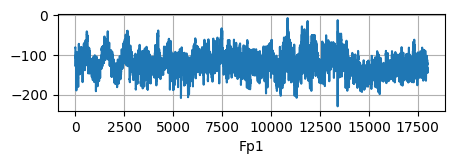

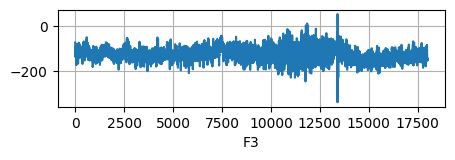

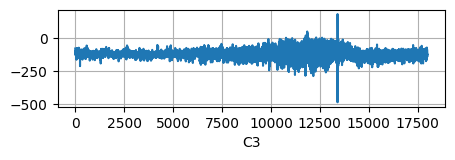

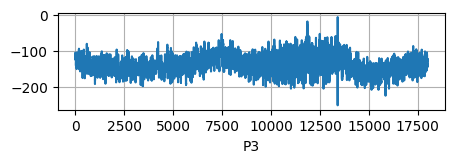

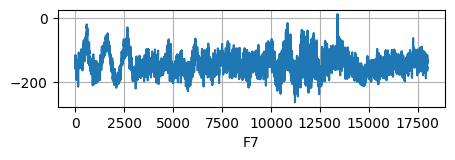

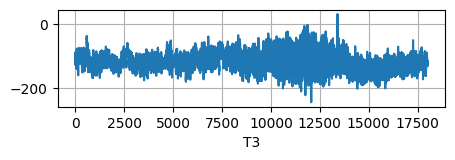

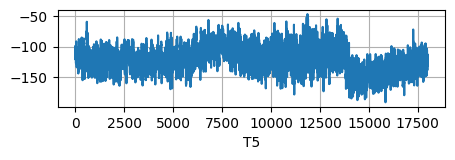

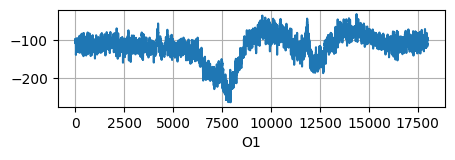

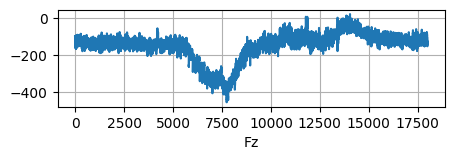

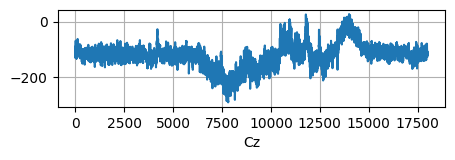

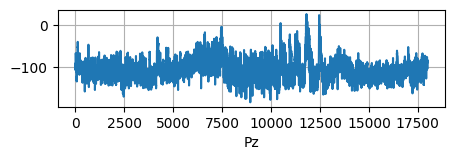

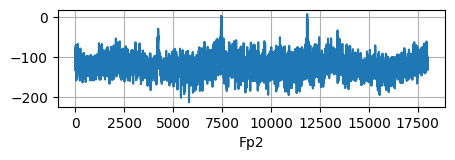

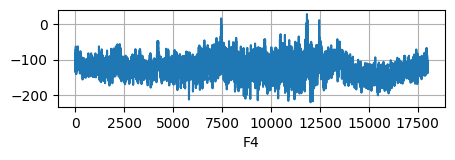

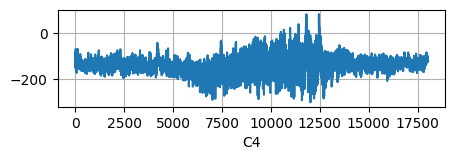

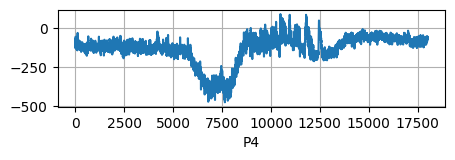

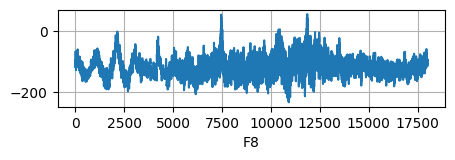

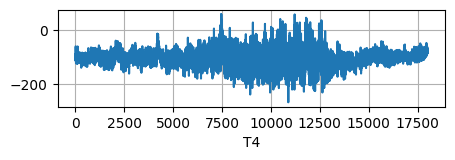

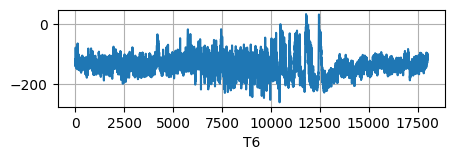

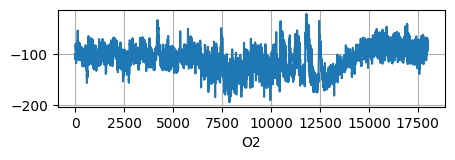

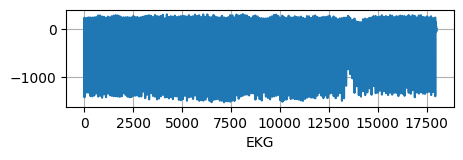

In [31]:
#Visualizing eeg data
plot_eeg(sample_eeg)

* From the above EEG data, we can observe that the training data consists of several sub ids which are each 50 sec long.
* On the other hand, EEG is a consolidated data where each 2000 samples represent a second.
* It is important to note that **test data only contains 50 secs of non-overlapping  EEG data**



In [32]:
#Reading spectogram data
sample_spg=train_spectrogram_dir/(str(sample_spectogram_id)+'.parquet')
pd.read_parquet(sample_spg)

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,631,6.36,6.59,6.60,7.30,4.48,8.400000,13.420000,13.85,16.010000,...,0.14,0.05,0.06,0.04,0.04,0.04,0.05,0.05,0.08,0.11
316,633,4.90,8.80,8.22,5.83,10.21,10.580000,10.250000,13.68,19.549999,...,0.16,0.08,0.06,0.06,0.07,0.04,0.06,0.09,0.07,0.08
317,635,6.07,7.85,11.26,9.20,8.18,9.130000,10.450000,15.09,23.020000,...,0.15,0.13,0.13,0.13,0.10,0.08,0.07,0.09,0.17,0.12
318,637,3.41,3.75,4.80,6.45,6.70,7.960000,8.160000,6.97,9.700000,...,0.13,0.11,0.13,0.07,0.11,0.12,0.09,0.16,0.19,0.19


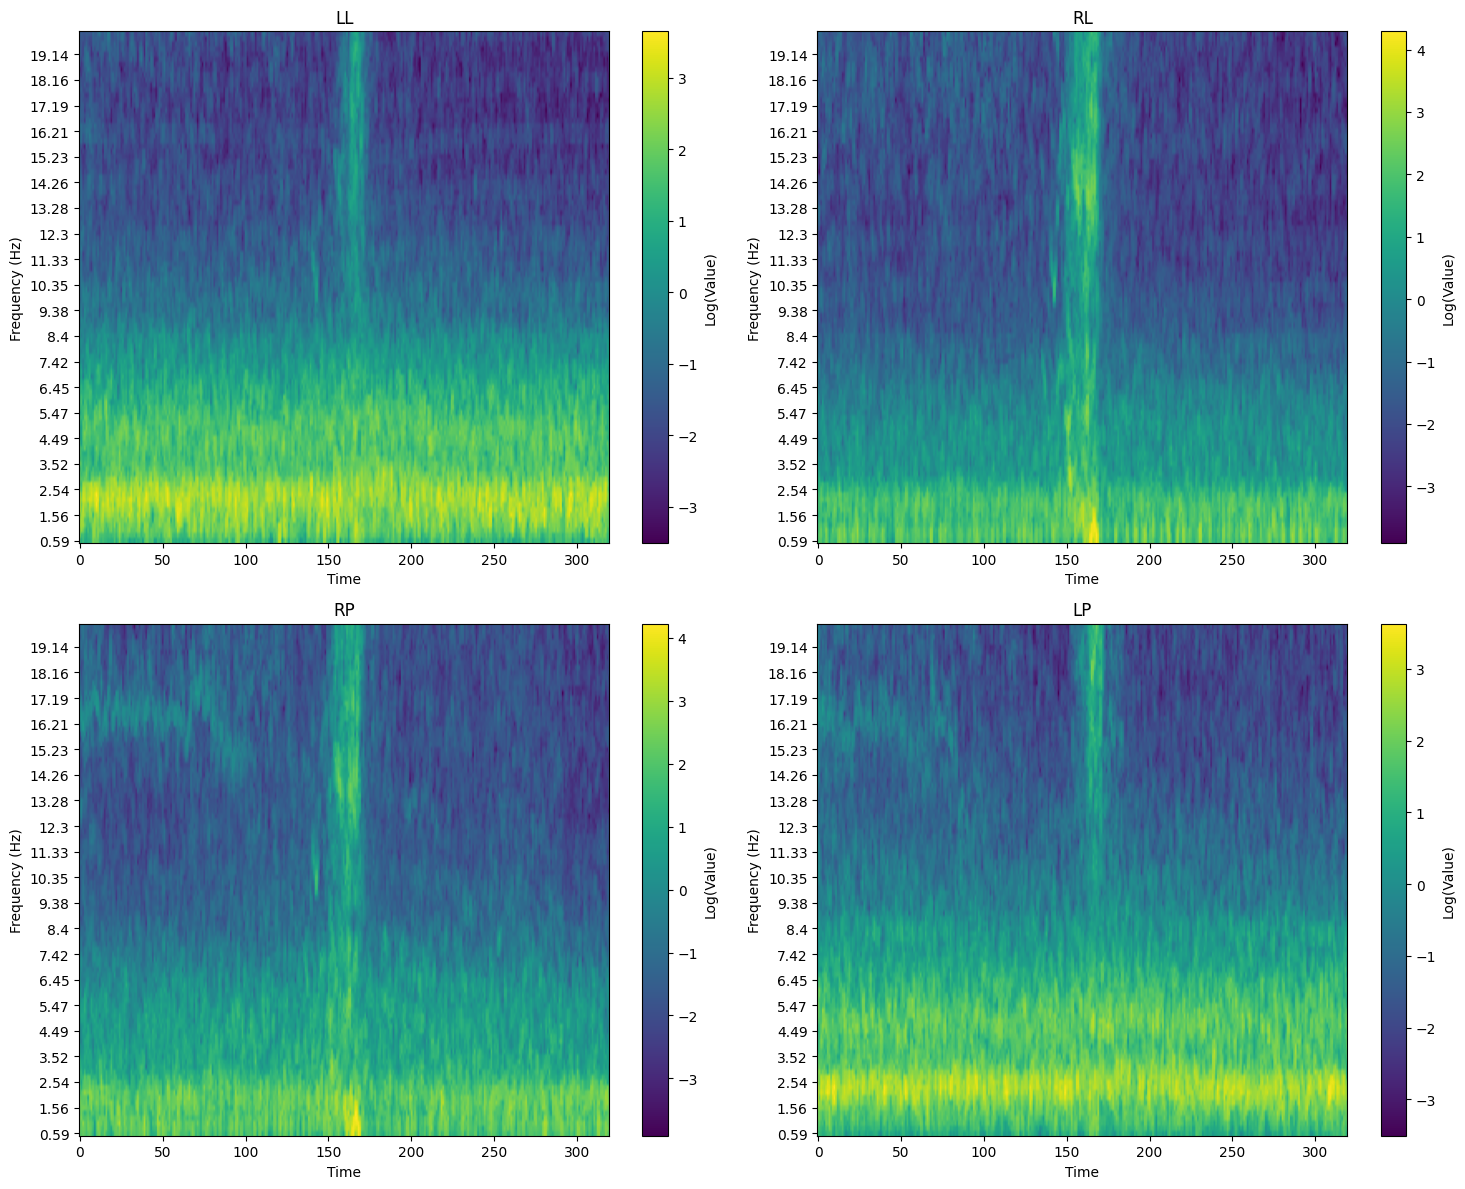

In [33]:
plot_spectrogram(sample_spg)

* From the above Spectrogram data, we can observe that the training data consists of several sub ids which are each 10 mins long.
* On the other hand, Spectrogram is a consolidated data where each row represents 2 secs 
* It is important to note that **test data only contains 10 mins of non-overlapping  Spectrogram data**

In [34]:
#Checking the occurence of spectrograms against eeg
train_data.groupby(['eeg_id'])['spectrogram_id'].nunique().unique()

array([1])

Hence,each eeg is associated with a unique spectrogram data

In [35]:
train_data.groupby(['spectrogram_id'])['eeg_id'].nunique().unique()

array([  1,   3,   2,   6,   7,   4,   9,   5,   8,  27,  11,  13,  35,
        15,  10,  12,  22,  21,  28,  24,  20, 107,  14,  17,  16,  32,
        18,  48,  23,  62,  53,  54,  39,  31])

There may be multiple EEGs for a single Spectrogram

In [36]:
#Each spectrogram ID may have multiple expert_consensus
train_data.groupby(['spectrogram_id'])['expert_consensus'].nunique().value_counts()

expert_consensus
1    10076
2      897
3      135
4       25
5        5
Name: count, dtype: int64

In [37]:
#Each eeg ID may have multiple expert_consensus
train_data.groupby(['eeg_id'])['expert_consensus'].nunique().value_counts()

expert_consensus
1    16306
2      666
3       94
4       22
5        1
Name: count, dtype: int64

From the above, we can see that both for spectrogram and EEG, there is usually a common expert consensus though a few may vary

In [38]:
train_data

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0


In the train data, each **eeg_sub_id** is associated with **50 sec of EEG data** and each **spectrogram_sub_id** is associated with **10 min of Spectrogram data**

# Extracting data corresponding to EEG Data

In [39]:
sample_eeg_id=train_data['eeg_id'][0]
sample_eeg=train_eegs_dir/(str(sample_eeg_id)+'.parquet')
sample_df=pd.read_parquet(sample_eeg)
sample_df

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


In [40]:
sample_train_data=train_data[train_data['eeg_id']==sample_eeg_id]
sample_train_data

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,total_vote,seizure_vote_n,lpd_vote_n,gpd_vote_n,lrda_vote_n,grda_vote_n,other_vote_n
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0


All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second.
hence for 18000 rows, time provided for this **EEG data =18000/200 =90 sec**

## Creating and Loading Datset for EEG

In [41]:
import torch
from torch.utils.data import Dataset,DataLoader,Subset

In [42]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
class EEGDataset(Dataset):
    
    def __init__(self,data,eeg_dir_path):
        self.data=data
        self.eeg_dir_path=eeg_dir_path
        self.targets=['seizure_vote',	'lpd_vote',	'gpd_vote',	'lrda_vote',	'grda_vote',	'other_vote']
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        sample_eeg_id=self.data.iloc[index]['eeg_id'] #Getting the id
        sample_eeg_offset=self.data.iloc[index]['eeg_label_offset_seconds']  #Getting the offset

        #Getting the  targets
        sample_eeg_target=self.data.iloc[index][self.targets]

        sample_eeg=self.eeg_dir_path/(str(sample_eeg_id)+'.parquet')  #Getting the EEG file 
        sample_eeg_df=pd.read_parquet(sample_eeg)  #Reading the parquet

        #Imputing values
        
        #sample_eeg_df=sample_eeg_df.bfill(axis=0) #Filling null values across rows
        #sample_eeg_df=sample_eeg_df.ffill(axis=0)

        #Getting the EEG data
        X=self.get_features(eeg_df=sample_eeg_df,eeg_offset=sample_eeg_offset).T #Transposing to get in the shape of (Channel,Timesteps)
        
        y=np.array(sample_eeg_target.values.astype('float32')) 
        y=torch.tensor(y)
        y=y.softmax(dim=-1)  #Since we want probability distribution
        

        return torch.tensor(X),y


    def get_features(self,eeg_df,eeg_offset):

        #Each row in eeg_df contains 1 of 200 samples per second
        
        #Checking for existence of atleast 50 secs or 10000 rows of data
        #if int(eeg_offset)*200+50*200<=len(eeg_df):
        truncated_df=eeg_df.iloc[int(eeg_offset)*200:int(eeg_offset)*200+50*200] #Collecting 50 secs of data
        eeg_array=truncated_df.to_numpy()  #Shape:(timesteps,features)
        
            
        #else:/
            #truncated_df=eeg_df.iloc[int(eeg_offset)*200:] #Collecting till last
            #eeg_array=truncated_df.to_numpy()

            #Padding to 10000 time steps
            #rows_to_add = 10000 - eeg_array.shape[0]
            #padding = ((0, rows_to_add), (0, 0))  # Pad rows at the end, no padding for columns
            #eeg_array = np.pad(eeg_array, padding, mode='mean')
        return eeg_array

    

    def target_dict(self):
        return {i:t for (i,t) in enumerate(self.targets)}
        
            
            
            
        

        
 

### Checking for null indexes

In [44]:
#Defining a function to get null indexes
def get_null_indexes(data,eeg_dir_path):
    null_index_list=[]
    for index in range(len(data)):
        eeg_id=data.iloc[index]['eeg_id'] #Getting the id
        eeg_offset=data.iloc[index]['eeg_label_offset_seconds']  #Getting the offset

        eeg_file=eeg_dir_path/(str(eeg_id)+'.parquet')  #Getting the EEG file 
        eeg_df=pd.read_parquet(eeg_file)  #Reading the parquet


        truncated_df=eeg_df.iloc[int(eeg_offset)*200:int(eeg_offset)*200+50*200] #Collecting 50 secs of data
        eeg_array=truncated_df.to_numpy()  #Shape:(timesteps,features).T #Transposing to get in the shape of (Channel,Timesteps)

        if np.isnan(eeg_array).any():
            null_index_list.append(index)

    return null_index_list
                

In [45]:
#Getting null indices

#null_index_list=get_null_indexes(data=train_data,eeg_dir_path=train_eegs_dir)

In [46]:
#Null list location
null_index_dir=Path('/kaggle/working')
null_index_path=null_index_dir/'null_index.json'

In [47]:
#Null index download path
null_index_download_path=Path('/kaggle/input')/'null-index-json/null_index.json'

In [48]:
#Storing files in an object
'''
with open(null_index_path,'w') as f:
    json.dump(null_index_list,f)
'''

"\nwith open(null_index_path,'w') as f:\n    json.dump(null_index_list,f)\n"

In [49]:
#Loading the list
with open(null_index_download_path,'r') as f:
    null_list=json.load(f)
    

In [50]:
print(f'No of null index:{len(null_list)}')

No of null index:3542


#### Splitting data into train & val

In [51]:
#Getting the non-null indices
non_null_indices=list(set(range(len(train_data)))-set(null_list))
print(f'All indices:{len(train_data)}')
print(f'Non null indices:{len(non_null_indices)}')

All indices:106800
Non null indices:103258


In [52]:
#Splitting the indices
train_split=0.8

train_indices=np.random.choice(non_null_indices,int((len(non_null_indices)*train_split)),replace=False).tolist()
val_indices=list(set(non_null_indices)-set(train_indices))



In [53]:
#Splitting the data based on indices

train_set=train_data.iloc[train_indices]
val_set=train_data.iloc[val_indices]

In [54]:
#Initialializing the dataset
train_eeg_ds=EEGDataset(data=train_set,eeg_dir_path=train_eegs_dir)
val_eeg_ds=EEGDataset(data=val_set,eeg_dir_path=train_eegs_dir)

In [55]:
#Checking length of dataset
print(f'Length of train dataset:{len(train_eeg_ds)}')
print(f'Length of val dataset:{len(val_eeg_ds)}')

Length of train dataset:82606
Length of val dataset:20652


In [56]:
#Checking shape of dataset
print(f'Shape of X in dataset:{train_eeg_ds[0][0].shape}')
print(f'Shape of y in dataset:{train_eeg_ds[0][1].shape}')

Shape of X in dataset:torch.Size([20, 10000])
Shape of y in dataset:torch.Size([6])


Hence we get the dataset in which  **feature** in the shape of **(channels,timesteps)** and **target** in the shape of (labels)

In [72]:
#Creating a subdataset for research purpose

train_sub_size=30000
val_sub_size=5000

train_sub_indices=np.random.choice(range(len(train_eeg_ds)),train_sub_size,replace=False)
val_sub_indices=np.random.choice(range(len(val_eeg_ds)),val_sub_size,replace=False)

train_sub_ds=Subset(train_eeg_ds,indices=train_sub_indices)
val_sub_ds=Subset(val_eeg_ds,indices=val_sub_indices)
print(f'Length of sub dataset:{len(train_sub_ds)}')

Length of sub dataset:30000


In [73]:
batch_size=32
#Creating a sub dataloader
train_sub_dl=DataLoader(train_sub_ds,batch_size=batch_size,shuffle=True)
val_sub_dl=DataLoader(val_sub_ds,batch_size=batch_size,shuffle=False)

In [74]:
print(f'Shape of X in dataloader:{next(iter(train_sub_dl))[0].shape}')
print(f'Shape of y in dataloader:{next(iter(train_sub_dl))[1].shape}')


Shape of X in dataloader:torch.Size([32, 20, 10000])
Shape of y in dataloader:torch.Size([32, 6])


In [75]:
sample_dl_X=next(iter(train_sub_dl))[0].to(device)
print(f'Shape of sample_dl={sample_dl_X.shape}')


Shape of sample_dl=torch.Size([32, 20, 10000])


In [76]:
#Getting full validation dataloader
val_eeg_dl=DataLoader(val_eeg_ds,batch_size=64)

In [117]:
#Getting the dict

target_dict=val_eeg_ds.target_dict()

# Defining the model

## Defining Utility functions

In [62]:
import torch
from torch import nn
from torch.nn import functional as F

import torchinfo

In [63]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [64]:
def train_model(train_dl,val_dl,model,loss_fn,optimizer,epochs,model_path=None,scheduler=None,best_loss=None):
    epoch_train_loss=[]
    epoch_val_loss=[]
    if best_loss:
        best_loss=best_loss
    else:
        best_loss=np.inf
    
    for i in range(epochs):
        #Training the model
        model.train()
        train_loss=0
        for n,(X,y) in enumerate(train_dl):
            X,y=X.to(device),y.to(device)
            y_pred=model(X)  #y_pred is softmax
            
            loss=loss_fn(torch.log(y_pred),y)  
    
            train_loss+=loss*y.shape[0]
            #Zero grad the optimizer
            optimizer.zero_grad()
            #Backpropagate
            loss.backward()
            #Updating parameters
            optimizer.step()
            #Tuning the scheduler
            if scheduler:
                scheduler.step()
            if n%10==0:
                print(f'Batch:{i}_{n} | Batch loss:{loss.item():.2f}')

           

        train_loss=(train_loss/len(train_dl.dataset)).item()
        print(f'Epoch:{i} | Train loss:{train_loss:.2f}')
        epoch_train_loss.append(train_loss)

        #Evaluating model
        model.eval()
        val_loss=0
        with torch.no_grad():
            for X,y in val_dl:
                X,y=X.to(device),y.to(device)
                y_pred=model(X)  #y_pred is softmax
                loss=loss_fn(torch.log(y_pred),y)
                val_loss+=loss*y.shape[0]
            val_loss=(val_loss/len(val_dl.dataset)).item()
            
            print(f'Epoch:{i} | Val loss:{val_loss:.2f}')
            epoch_val_loss.append(val_loss)
        #Saving model
        if model_path:
            model_path.parent.mkdir(parents=True,exist_ok=True)
            if val_loss<best_loss:
                torch.save(model.state_dict(),model_path)  #saving the state dict
                best_loss=val_loss
                
                
            
    return epoch_train_loss,epoch_val_loss



In [65]:
#Defining evaluation function

def eval_model(model,val_dl,loss_fn):
    model.eval()
    val_loss=0
    with torch.no_grad():
        for (X,y) in val_dl:
            X,y=X.to(device),y.to(device)
            y_pred=model(X)
            loss=loss_fn(torch.log(y_pred),y)
            val_loss+=loss*y.shape[0]
        val_loss=(val_loss/len(val_dl.dataset)).item()
    return val_loss


In [66]:
#Defining a function to  get prediction
def predict_labels(model,eeg_data,target_dict):
    model.eval()
    pred=model(eeg_data).detach().cpu().numpy()
    return pd.DataFrame(pred,columns=target_dict.values())


In [67]:
#Defining a function to  get load pre-trained models
def load_pretrained(model,state_dict_path):
    if torch.cuda.is_available()==False:
        map_location=torch.device('cpu')
    else:
        map_location=torch.device('cuda')
    
    model.load_state_dict(torch.load(state_dict_path,weights_only=True,map_location=map_location))
    return model

In [107]:
#Paths for pretrained model
eeg_model_dir=Path('/kaggle/input')
eeg_simple_state=eeg_model_dir/'eeg-simple-model'/'pytorch'/'default'/'3'/'eeg_model.pth'
eeg_resnet_state=eeg_model_dir/'eeg-resnet-model'/'pytorch'/'default'/'2'/'eeg_r_model.pth'

## EEGNet + LSTM

There may be several options of using CNN based or LSTM based architecture.


We will consider implementing the EEGNet architecture, defined in the following publication:

**EEGNet: A Compact Convolutional Neural Network
for EEG-based Brain-Computer Interfaces**
https://arxiv.org/pdf/1611.08024

In addition to the Temporal Convolution,Spatial Convolution and Separable Convolution layers,an **LSTM layer** is also added to better capture the temporal variation of data before passing into the Linear layers 

Following is the overall view of the EEGNet architecture:
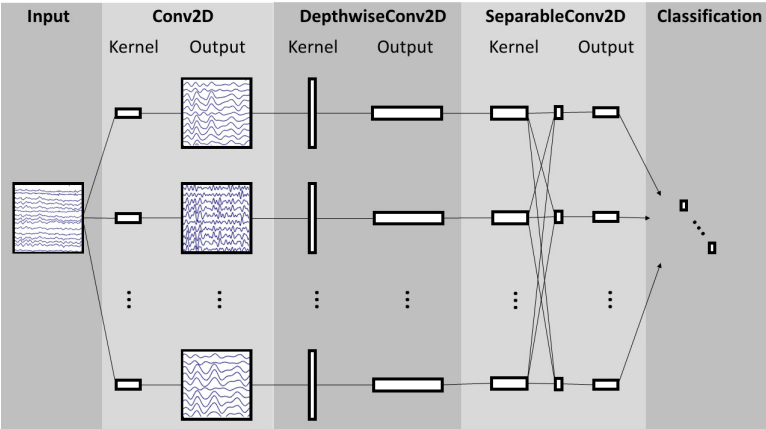

In [108]:
class EEGNet(nn.Module):

    def __init__(self,num_features,num_targets,num_temp_filters=40,num_spatial_filters=40,dropout_rate_cn=0.1,dropout_rate_fc=0.3):
        super().__init__()
        self.dropout_rate_cn=dropout_rate_cn
        self.dropout_rate_fc=dropout_rate_fc
        self.num_targets=num_targets
        #Normalizing across channels
        self.bn1=nn.BatchNorm1d(num_features=num_features) 
        
        #Using a filter to convolve across temporal direction
        self.temp_conv=nn.Conv2d(in_channels=1,out_channels=num_temp_filters,kernel_size=(1,64),bias=False)
        #Normalizing across temporal features
        self.bn2=nn.BatchNorm2d(num_features=num_temp_filters)
        
        #Using a filter to convolve across spatial direction
        self.depth_conv=nn.Conv2d(in_channels=num_temp_filters,out_channels=num_spatial_filters,kernel_size=(num_features,1),bias=False)
        #Normalizing across spatial features
        self.bn3=nn.BatchNorm2d(num_features=num_spatial_filters)
        #Average pooling
        self.avgpool1=nn.AvgPool2d(kernel_size=(1,8))
        
        
        
        #Using a filter to convolve across features
        self.sep_conv=nn.Conv2d(in_channels=num_spatial_filters,out_channels=num_spatial_filters,kernel_size=(1,16),bias=False)
        #Normalizing across  features
        self.bn4=nn.BatchNorm2d(num_features=num_spatial_filters) 
        #Average pooling
        self.avgpool2=nn.AvgPool2d(kernel_size=(1,16))
        
        #Applying LSTM
        self.lstm=None

        #Normalizing across  features
        self.bn5=None 

        
        #Linear layer 1
        self.linear1=None
        #Applying batch norm
        self.bn6=None
        #Linear layer 2
        self.linear2=None
        #Applying batch norm
        self.bn7=None

        #Dropout
        self.dropout_cn=nn.Dropout(p=dropout_rate_cn)
        self.dropout_fc=nn.Dropout(p=dropout_rate_fc)
    
    
    

    def forward(self,x):
        x=self.bn1(x)     #Input shape (batch_size,features,timesteps)
        x=torch.unsqueeze(x,1)  #Output shape (batch_size,1,features,timesteps)
        
        x=self.temp_conv(x)     #Output shape (batch_size,filters,features,timesteps)
        x=self.bn2(x)           
        x=F.elu(x)
        
        x=self.depth_conv(x)    #Output shape (batch_size,features,1,timesteps)
        x=self.bn3(x)
        x=F.elu(x)
        x=self.avgpool1(x)
        
       
        
        x=self.sep_conv(x)     #Output shape (batch_size,features,1,timesteps)
        x=self.bn4(x)
        x=F.elu(x)
        x=self.avgpool2(x)
       
        
       
        x=x.squeeze(-2)        #Output shape (batch_size,features,timesteps)
        
        lstm_in=x.permute(0,2,1)     #Output shape (batch_size,timesteps,features)

        lstm_in=self.dropout_cn(lstm_in)
        
        

        if self.lstm==None:
            features=lstm_in.shape[-1]
            self.lstm=nn.LSTM(input_size=features, hidden_size=features, num_layers=1, bias=True, 
                              batch_first=True, dropout=0.0, bidirectional=False).to(device)

        
        lstm_out=self.lstm(lstm_in)[0][:,-1,:]   #Output shape (batch_size,features) 
        
        
        if self.bn5==None:
            in_features = lstm_out.shape[1]
            self.bn5 = nn.BatchNorm1d(num_features=in_features).to(device)
        lstm_out=self.bn5(lstm_out)

       
        x=nn.Flatten()(x)  #Output shape (batch_size,features)
        #Concatenating lsmtm output with original features
        x=torch.cat([x,lstm_out],dim=-1)
        x=self.dropout_fc(x)
       
        if self.linear1==None:
            in_features = x.shape[1]
            self.linear1 = nn.Linear(in_features,in_features//10 ).to(device)
        x=self.linear1(x)
        if self.bn6==None:
            in_features = x.shape[1]
            self.bn6 = nn.BatchNorm1d(num_features=in_features).to(device)
        x=self.bn6(x)
        x=F.elu(x)
        x=self.dropout_fc(x)
            
        if self.linear2==None:
            in_features = x.shape[1]
            self.linear2 = nn.Linear(in_features,self.num_targets ).to(device)
        x=self.linear2(x)


        
        x=F.softmax(x,dim=-1)      
        
        return x
        


In [109]:
#Initililizing the model
eegnet=EEGNet(num_features=20,num_targets=6,num_temp_filters=20,num_spatial_filters=40,dropout_rate_cn=0.1,dropout_rate_fc=0.3).to(device)

In [110]:
out=eegnet(sample_dl_X)
print(f'Shape of output:{out.shape}')


Shape of output:torch.Size([32, 6])


In [111]:
torchinfo.summary(eegnet,input_data=sample_dl_X)

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [32, 6]                   --
├─BatchNorm1d: 1-1                       [32, 20, 10000]           40
├─Conv2d: 1-2                            [32, 20, 20, 9937]        1,280
├─BatchNorm2d: 1-3                       [32, 20, 20, 9937]        40
├─Conv2d: 1-4                            [32, 40, 1, 9937]         16,000
├─BatchNorm2d: 1-5                       [32, 40, 1, 9937]         80
├─AvgPool2d: 1-6                         [32, 40, 1, 1242]         --
├─Conv2d: 1-7                            [32, 40, 1, 1227]         25,600
├─BatchNorm2d: 1-8                       [32, 40, 1, 1227]         80
├─AvgPool2d: 1-9                         [32, 40, 1, 76]           --
├─Dropout: 1-10                          [32, 76, 40]              --
├─LSTM: 1-11                             [32, 76, 40]              13,120
├─BatchNorm1d: 1-12                      [32, 40]                  80


In [112]:
#Loading pre-trained model
eegnet=load_pretrained(model=eegnet,state_dict_path=eeg_simple_state)

In [104]:
#Defining the hyperparameters
config_eegnet={
    'train_dl':train_sub_dl,
    'val_dl':val_sub_dl,
    'model':eegnet,
    'model_path':Path('/kaggle/working')/'model_dir'/'eeg_model.pth',
    'epochs':5,
    'best_loss':np.inf
}



In [105]:
#Defining loss and optimization functions
loss_fn=nn.KLDivLoss(reduction="batchmean")

optimizer=torch.optim.AdamW(eegnet.parameters(), lr=0.001)

scheduler=torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config_eegnet['epochs'],
        steps_per_epoch=len(config_eegnet['train_dl']),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=1000,
    )

In [106]:
train_model(train_dl=config_eegnet['train_dl'],
            val_dl=config_eegnet['val_dl'],
            model=eegnet,loss_fn=loss_fn,optimizer=optimizer,
            epochs=config_eegnet['epochs'],
            scheduler=scheduler,
            model_path=config_eegnet['model_path'],
            best_loss=config_eegnet['best_loss'])

Batch:0_0 | Batch loss:0.95
Batch:0_10 | Batch loss:1.26
Batch:0_20 | Batch loss:1.33
Batch:0_30 | Batch loss:1.14
Batch:0_40 | Batch loss:1.03
Batch:0_50 | Batch loss:1.29
Batch:0_60 | Batch loss:1.15
Batch:0_70 | Batch loss:1.06
Batch:0_80 | Batch loss:1.11
Batch:0_90 | Batch loss:1.37
Batch:0_100 | Batch loss:1.07
Batch:0_110 | Batch loss:1.16
Batch:0_120 | Batch loss:1.16
Batch:0_130 | Batch loss:1.36
Batch:0_140 | Batch loss:1.18
Batch:0_150 | Batch loss:1.04
Batch:0_160 | Batch loss:0.84
Batch:0_170 | Batch loss:0.99
Batch:0_180 | Batch loss:1.12
Batch:0_190 | Batch loss:1.09
Batch:0_200 | Batch loss:1.16
Batch:0_210 | Batch loss:1.13
Batch:0_220 | Batch loss:0.97
Batch:0_230 | Batch loss:1.01
Batch:0_240 | Batch loss:0.93
Batch:0_250 | Batch loss:0.97
Batch:0_260 | Batch loss:1.00
Batch:0_270 | Batch loss:1.01
Batch:0_280 | Batch loss:1.15
Batch:0_290 | Batch loss:0.95
Batch:0_300 | Batch loss:1.03
Batch:0_310 | Batch loss:1.26
Batch:0_320 | Batch loss:0.94
Batch:0_330 | Batch l

([1.0216962099075317,
  0.9062724709510803,
  0.829832911491394,
  0.7642953395843506,
  0.7261843085289001],
 [1.1257078647613525,
  1.0203773975372314,
  1.13164222240448,
  0.9855639338493347,
  1.084631323814392])

In [113]:
#Evaluating model
eval_model(model=eegnet,val_dl=val_eeg_dl,loss_fn=loss_fn)

0.9816569685935974

#### The **Kullback Leibler Divergence Loss** for entire val dataset with the trained model is **0.98**.

## EEGNet with Resnet

In this model,instead of using a fixed size kernel for temporal convolution, we have used **different sizes of kernel**,which would **undergo separate  convolutions in parallel**,before concatenation.
Further instead of a single convolution layers, **multiple residual blocks of convolution layer** have been used,which allows for deeper networks with more feature extraction.



In [69]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,dropout, downsampling):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding='same', bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding='same', bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out



In [70]:
class EEGNet_resnet(nn.Module):
    def __init__(self, num_features, num_targets, temporal_filter_lengths, num_temp_filters=24, dropout_rate_cn=0.1,dropout_rate_fc=0.3,res_blocks=6):
        super().__init__()
        self.num_temp_filters=num_temp_filters
        
        self.dropout_rate_cn = dropout_rate_cn
        self.dropout_rate_fc = dropout_rate_fc
        self.num_targets = num_targets
        self.temporal_filter_lengths = temporal_filter_lengths  # Store filter lengths
        self.res_blocks=res_blocks

        # Normalizing across channels
        self.bn1 = nn.BatchNorm1d(num_features=num_features)

        # Parallel convolutions with multiple filter lengths
        self.parallel_convs = nn.ModuleList()
        for filter_length in temporal_filter_lengths:
            self.parallel_convs.append(
                nn.Sequential(
                    #Using a filter to convolve across temporal direction
                    nn.Conv1d(in_channels=num_features, out_channels=num_temp_filters, kernel_size=filter_length,padding='same',bias=False),
                    nn.BatchNorm1d(num_features=num_temp_filters),
                    nn.ReLU(),
                    nn.AvgPool1d(kernel_size=4, stride=2, padding=0)
                     )
                    )
       
        # Using a filter to convolve across features
        self.sep_conv = nn.Conv1d(in_channels=num_temp_filters*len(temporal_filter_lengths), out_channels=num_temp_filters*len(temporal_filter_lengths), kernel_size=8,stride=2,bias=False)
        # Normalizing across  features
        self.bn4 = nn.BatchNorm1d(num_features=num_temp_filters*len(temporal_filter_lengths))
        # Average pooling
        self.avgpool2 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)

        #Making resnet block
        self.block = self._make_resnet_layer(kernel_size=16, stride=1,blocks=res_blocks, dropout=dropout_rate_cn)

        # Applying LSTM
        self.lstm = None

        # Normalizing across  features
        self.bn5 = None

        # Linear layer 1
        self.linear1 = None
        # Applying batch norm
        self.bn6 = None
        # Linear layer 2
        self.linear2 = None
        # Applying batch norm
        self.bn7 = None
        # Linear layer 3
        self.linear3 = None
        # Applying batch norm
        self.bn8= None

        #Dropout
        self.dropout_cn=nn.Dropout(p=dropout_rate_cn)
        self.dropout_fc=nn.Dropout(p=dropout_rate_fc)

        #ReLU
        self.relu=nn.ReLU()
    
    #Function to make resnet layers
    def _make_resnet_layer(self, kernel_size, stride, blocks,dropout):
        planes=self.num_temp_filters*len(self.temporal_filter_lengths)
        layers = []
        downsample = None
       

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=planes, out_channels=planes, kernel_size=kernel_size,
                                       stride=stride, dropout=dropout, downsampling=downsampling))

        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.bn1(x)  # Input shape (batch_size, features, timesteps)
        
        # Apply each temporal convolution in parallel and concatenate the results
        temp_outputs = []
        for parallel_conv in self.parallel_convs:
            temp_output=parallel_conv(x)
            temp_outputs.append(temp_output)
          
        x = torch.cat(temp_outputs, dim=1)  # Output shape (batch_size,features*temporal_length, timesteps)

        
        x = self.sep_conv(x)  # Output shape (batch_size, features, timesteps)
        x = self.bn4(x)
        
        #Apply resnet convolution blocks
        x = self.block(x)  # Output shape (batch_size, features, timesteps)
        
        if self.bn5 is None:
            in_features = x.shape[1]
            self.bn5 = nn.BatchNorm1d(num_features=in_features).to(device)
        x = self.bn5(x)  # Output shape (batch_size, features, timesteps)
        
        #Apply LSTM 
        lstm_in = x.permute(0, 2, 1)  # Output shape (batch_size, timesteps, features)
         
        if self.lstm is None:
            lstm_features = lstm_in.shape[-1]
            self.lstm = nn.LSTM(input_size=lstm_features, hidden_size=lstm_features , num_layers=1, bias=True,
                                        batch_first=True, bidirectional=False).to(device)

        #taking last timestep
        lstm_out = self.lstm(lstm_in)[0][:,-1,:]  # Output shape (batch_size, features)

        if self.bn6 is None:
            in_features = lstm_out.shape[1]
            self.bn6 = nn.BatchNorm1d(num_features=in_features).to(device)
        lstm_out = self.bn6(lstm_out)

        #Flattening resnet output
        x = nn.Flatten()(x)  # Output shape (batch_size, features)
        
        #Concatenating resnet  and lstm output
        x=torch.cat([x,lstm_out],dim=-1)    
        x = self.dropout_fc(x)
       
        #Applying linear layer
        if self.linear1 is None:
            in_features = x.shape[1]
            self.linear1 = nn.Linear(in_features,in_features//8 ).to(device)
        x = self.linear1(x)
        if self.bn7 is None:
            in_features = x.shape[1]
            self.bn7 = nn.BatchNorm1d(num_features=in_features).to(device)
        x = self.bn7(x)
        x = self.relu(x)
        
       
        x = self.dropout_fc(x)

        if self.linear2 is None:
            in_features = x.shape[1]
            self.linear2 = nn.Linear(in_features, self.num_targets).to(device)
        x = self.linear2(x)
     
      
        x = F.softmax(x, dim=-1)
       
        return x


In [80]:
#Initililizing the model
eegnet_r=EEGNet_resnet(num_features=20, num_targets=6, temporal_filter_lengths=[4,8,12], num_temp_filters=24, dropout_rate_cn=0.1,dropout_rate_fc=0.3,res_blocks=7).to(device)

In [81]:
out=eegnet_r(sample_dl_X)
print(f'Shape of output:{out.shape}')


Shape of output:torch.Size([32, 6])


In [82]:
torchinfo.summary(eegnet_r,input_data=sample_dl_X)

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet_resnet                            [32, 6]                   --
├─BatchNorm1d: 1-1                       [32, 20, 10000]           40
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-1                   [32, 24, 4999]            --
│    │    └─Conv1d: 3-1                  [32, 24, 10000]           1,920
│    │    └─BatchNorm1d: 3-2             [32, 24, 10000]           48
│    │    └─ReLU: 3-3                    [32, 24, 10000]           --
│    │    └─AvgPool1d: 3-4               [32, 24, 4999]            --
│    └─Sequential: 2-2                   [32, 24, 4999]            --
│    │    └─Conv1d: 3-5                  [32, 24, 10000]           3,840
│    │    └─BatchNorm1d: 3-6             [32, 24, 10000]           48
│    │    └─ReLU: 3-7                    [32, 24, 10000]           --
│    │    └─AvgPool1d: 3-8               [32, 24, 4999]            --
│    └─Se

In [95]:
#Loading pre-trained model
eegnet_r=load_pretrained(model=eegnet_r,state_dict_path=eeg_resnet_state)

In [96]:
#Defining the hyperparameters
config_eegnet_r={
    'train_dl':train_sub_dl,
    'val_dl':val_sub_dl,
    'model':eegnet_r,
    'model_path':Path('/kaggle/working')/'model_dir'/'eeg_r_model.pth',
    'epochs':3,
    'best_loss':0.78 #The best loss for pre-trained parameter
}

In [97]:
#Defining loss and optimization functions
loss_fn=nn.KLDivLoss(reduction="batchmean")

optimizer=torch.optim.AdamW(eegnet_r.parameters(), lr=0.5*1e-4)

scheduler=torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.5*1e-4,
        epochs=config_eegnet_r['epochs'],
        steps_per_epoch=len(config_eegnet_r['train_dl']),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

In [98]:
train_model(train_dl=config_eegnet_r['train_dl'],
            val_dl=config_eegnet_r['val_dl'],
            model=eegnet_r,
            loss_fn=loss_fn,optimizer=optimizer,
            epochs=config_eegnet_r['epochs'],
            scheduler=scheduler,
            model_path=config_eegnet_r['model_path'],
            best_loss=config_eegnet_r['best_loss'])

Batch:0_0 | Batch loss:0.52
Batch:0_10 | Batch loss:0.78
Batch:0_20 | Batch loss:0.63
Batch:0_30 | Batch loss:0.75
Batch:0_40 | Batch loss:0.63
Batch:0_50 | Batch loss:0.54
Batch:0_60 | Batch loss:0.58
Batch:0_70 | Batch loss:0.98
Batch:0_80 | Batch loss:0.52
Batch:0_90 | Batch loss:0.67
Batch:0_100 | Batch loss:0.68
Batch:0_110 | Batch loss:0.64
Batch:0_120 | Batch loss:0.58
Batch:0_130 | Batch loss:0.39
Batch:0_140 | Batch loss:0.55
Batch:0_150 | Batch loss:0.78
Batch:0_160 | Batch loss:0.64
Batch:0_170 | Batch loss:0.76
Batch:0_180 | Batch loss:0.59
Batch:0_190 | Batch loss:0.74
Batch:0_200 | Batch loss:0.70
Batch:0_210 | Batch loss:0.45
Batch:0_220 | Batch loss:0.58
Batch:0_230 | Batch loss:0.59
Batch:0_240 | Batch loss:0.72
Batch:0_250 | Batch loss:0.50
Batch:0_260 | Batch loss:0.61
Batch:0_270 | Batch loss:0.53
Batch:0_280 | Batch loss:0.85
Batch:0_290 | Batch loss:0.73
Batch:0_300 | Batch loss:0.57
Batch:0_310 | Batch loss:0.59
Batch:0_320 | Batch loss:0.63
Batch:0_330 | Batch l

([0.6145927906036377, 0.6106943488121033, 0.6078039407730103],
 [0.9494507312774658, 0.8894953727722168, 0.9980834722518921])

In [88]:
#Evaluating model
eval_model(model=eegnet_r,val_dl=val_eeg_dl,loss_fn=loss_fn)

0.7847901582717896

#### The **Kullback Leibler Divergence Loss** for entire val dataset with the trained model is **0.78**.

This is a significant improvement over the simpler model without residual blocks

# Predicting with EEG Data

In [115]:
#Loading a sample data
sample_index=np.random.choice(np.arange(len(val_eeg_ds)),1).item()

sample_data_X=val_eeg_ds[sample_index][0].unsqueeze(0).to(device)
sample_data_y=val_eeg_ds[sample_index][1]

In [118]:
#Actual
pd.DataFrame(sample_data_y.numpy().reshape(1,6),columns=target_dict.values())

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,0.039864,0.039864,0.039864,0.039864,0.039864,0.800682


In [119]:
#Predicting with eegnet resnet model
predict_labels(model=eegnet_r,eeg_data=sample_data_X,target_dict=target_dict)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,0.194167,0.074226,0.137949,0.056943,0.049294,0.487422


# Extracting data corresponding to Spectrogram Data

In [ ]:
train_data

In [ ]:
sample_spg_id=train_data['spectrogram_id'][0]
sample_spg=train_spectrogram_dir/(str(sample_spg_id)+'.parquet')
pd.read_parquet(sample_spg)

In [ ]:
train_data[train_data['spectrogram_id']==sample_spg_id]

All of the Spectrogram data (for both train and test) was collected for 2 sec per row.
hence for 320 rows, time provided for this **Spectrogram data =320*2 =640 sec**

Ecah sub-id is **10 min long or 600 sec long**

## Creating and Loading Datset for Spectrogram

In [ ]:
class SPGDataset(Dataset):
    
    def __init__(self,data,eeg_dir_path):
        self.data=data
        self.spg_dir_path=spg_dir_path
        self.targets=['seizure_vote',	'lpd_vote',	'gpd_vote',	'lrda_vote',	'grda_vote',	'other_vote']
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        sample_spg_id=self.data.iloc[index]['spectrogram_id'] #Getting the id
        sample_spg_offset=self.data.iloc[index]['spectrogram_label_offset_seconds']  #Getting the offset

        #Getting the  targets
        sample_spg_target=self.data.iloc[index][self.targets]

        sample_spg=self.spg_dir_path/(str(sample_spg_id)+'.parquet')  #Getting the SPG file 
        sample_spg_df=pd.read_parquet(sample_spg)  #Reading the parquet
        l
        sample_spg_df=sample_eeg_df.bfill(axis=0) #Filling null values across rows
        sample_spg_df=sample_eeg_df.ffill(axis=0)

        #Getting the SPG data
        X=self.get_features(spg_df=sample_spg_df,spg_offset=sample_spg_offset).T #Transposing to get in the shape of (Channel,Timesteps)
        
        y=np.array(sample_spg_target.values.astype('float32')) 
        y=torch.tensor(y)
        y=y.softmax(dim=-1)  #Since we want probability distribution
        

        return torch.tensor(X),y


    def get_features(self,spg_df,spg_offset):

        #Each row in spg_df contains 2 sec of data and each upto 10 min or 600 sec of data
        
        #Checking for existence of atleast 50 secs or 10000 rows of data
        #if int(eeg_offset)*200+50*200<=len(eeg_df):
        
        truncated_df=spg_df.iloc[int(spg_offset)/2:(int(spg_offset)+600)/2] #Collecting 600 secs of data
        
        eeg_array=truncated_df.to_numpy()  #Shape:(timesteps,features)
        
            
        #else:
            #truncated_df=eeg_df.iloc[int(eeg_offset)*200:] #Collecting till last
            #eeg_array=truncated_df.to_numpy()

            #Padding to 10000 time steps
            #rows_to_add = 10000 - eeg_array.shape[0]
            #padding = ((0, rows_to_add), (0, 0))  # Pad rows at the end, no padding for columns
            #eeg_array = np.pad(eeg_array, padding, mode='mean')
        return eeg_array

    

    def target_dict(self):
        return {i:t for (i,t) in enumerate(self.targets)}
        
            
            
            
        

In [ ]:
def plot_spectrogram(spectrogram_path):
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
